# Exploring SNSF Public Data

## Foreword

The [Swiss National Science Foundation](http://www.snf.ch/en/Pages/default.aspx) (SNSF) is the leading public science funding agency in Switzerland.  In _GrantExport_, the SNSF provides detailed information about approved grants.  In _PersonExport_, it also provides details about people associated to each grant.  Other tables provide further data about publications, outputs, and collaborations reported by applicants.  You can find the datasets and their documentation in [p3.snf.ch](http://p3.snf.ch/Pages/DataAndDocumentation.aspx).

Prior to exploring the data, I performed some cleaning operations on _GrantExport_ and on _PersonExport_.

In this notebook, we will look at the data in _GrantExport_ and _PersonExport_ and try to get some insights on how funding differs for men and women.

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(12, 8)})

# tidy datasets
grants=pd.read_feather('data/project.feather')
grantees=pd.read_feather('data/grantee.feather')
people=pd.read_feather('data/person.feather')

## Overview

Quick inspection of each dataset, one-by-one.

In [2]:
people.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111903 entries, 0 to 111902
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   index           111903 non-null  int64   
 1   person_id_snsf  111903 non-null  int64   
 2   gender          111903 non-null  category
 3   first_name      111896 non-null  object  
 4   last_name       111903 non-null  object  
dtypes: category(1), int64(2), object(2)
memory usage: 3.5+ MB


In [3]:
grantees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255507 entries, 0 to 255506
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   index           255507 non-null  int64 
 1   person_id_snsf  255507 non-null  int64 
 2   role            255507 non-null  object
 3   project_number  255507 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ MB


In [4]:
grants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74519 entries, 0 to 74518
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   index               74519 non-null  int64         
 1   project_number      74519 non-null  int64         
 2   programme           74479 non-null  category      
 3   funding_instrument  74519 non-null  category      
 4   domain              74020 non-null  category      
 5   topic               70748 non-null  category      
 6   discipline_name     74519 non-null  category      
 7   discipline_number   74519 non-null  int64         
 8   start_date          74517 non-null  datetime64[ns]
 9   end_date            74517 non-null  datetime64[ns]
 10  approved_amount     61387 non-null  float64       
dtypes: category(5), datetime64[ns](2), float64(1), int64(3)
memory usage: 3.9 MB


In [5]:
assert any(grants.project_number.duplicated()) == False, 'project_number contains duplicated entries'

In [6]:
# time range
grants.start_date.min(), grants.end_date.max()

(Timestamp('1975-01-06 00:00:00'), Timestamp('2025-10-31 00:00:00'))

_GrantExport_ contains ca. 74.5k grants, spanning across 50 years, from 1975 to 2025.

### Temporal trends

#### Approved grants

In [7]:
# 2 grants missing start- and end-date: grants[grants['start_date'].isnull()]
grants=grants.dropna(subset=['start_date'])
grants['year'] = grants['start_date'].dt.year

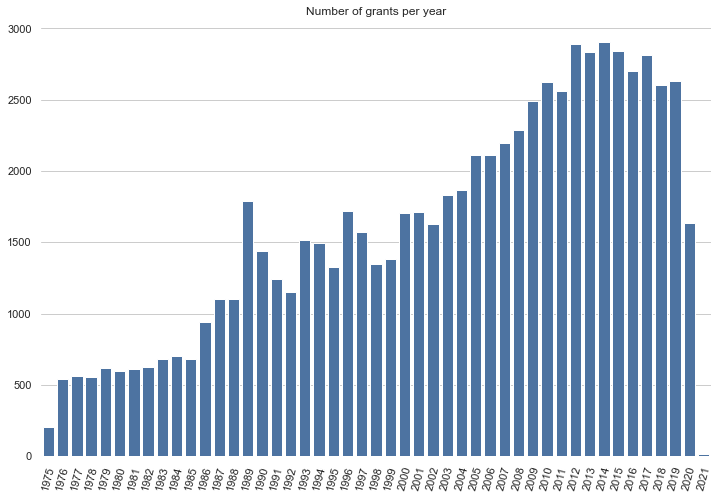

In [8]:
sns.set_style("whitegrid")
plt.box(on=None) 
g = sns.countplot(x='year', data=grants, color='#3f72af')
g.set_xlabel('')
g.set_ylabel('')
g.set_title('Number of grants per year')
g.set_xticklabels(g.get_xticklabels(), rotation=75, horizontalalignment='center')
g;

The number of grants nearly duplicated in 20 years.

#### Funding commitments

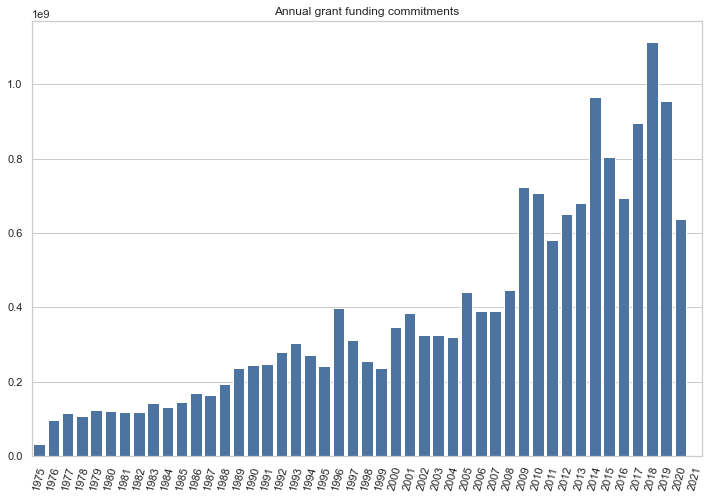

In [9]:
annual_funding = grants.groupby(['year'])['approved_amount'].sum().reset_index()
g = sns.barplot(x='year', y='approved_amount', data=annual_funding, color='#3f72af')
g.set_xlabel('')
g.set_ylabel('')    
g.set_title('Annual grant funding commitments')
g.set_xticklabels(g.get_xticklabels(), rotation=75, horizontalalignment='center', fontweight='light')
g;

In [10]:
annual_counts = grants.groupby(['year']).size().reset_index().rename(columns={0:'count'})
annual_stats = annual_counts.merge(annual_funding, on='year')
annual_stats = annual_stats.query('year < 2020')

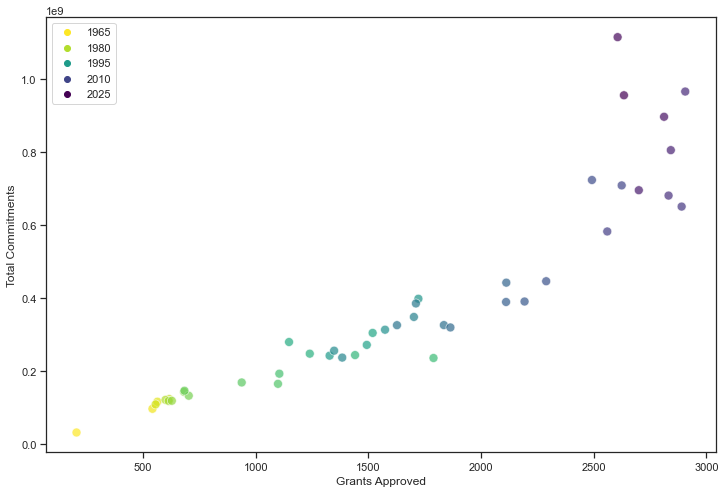

In [11]:
sns.set_style("ticks")
g = sns.scatterplot(x="count", y="approved_amount", hue=annual_stats.year.tolist(), palette='viridis_r', alpha=.7, s = 80, data=annual_stats)
g.set_xlabel('Grants Approved')
g.set_ylabel('Total Commitments')  
g;

A scatterplot between the annual funding commitments and the grants approved shows a higher spread in more recent years.

## Role and gender

In this section, we consider both the role and the gender of the person involved in the project.  The totals are the following:

In [12]:
(grantees
 .merge(people[['person_id_snsf', 'gender']], on='person_id_snsf')
 .groupby(['gender', 'role']).size())

gender  role                 
female  applicant                 6657
        contact_person             220
        employee                 50823
        partner                   1529
        practice_partner           256
        responsible_applicant    15952
male    applicant                40956
        contact_person             841
        employee                 77379
        partner                   4470
        practice_partner           547
        responsible_applicant    59158
dtype: int64

### Project leaders

A project leader is a scientist where `role == 'responsible_applicant'`.

In [13]:
# grants represented by their main applicants
pi = grantees.query('role == "responsible_applicant"').merge(grants, on='project_number')
# adding gender from people table
pi = pi.merge(people[['person_id_snsf', 'gender']], on='person_id_snsf')
pi = pi.drop(['index_x', 'index_y'], axis=1)

In [14]:
annual_counts = pi.groupby(['year', 'gender']).size().reset_index().rename(columns={0:'count'})
annual_funding = pi.groupby(['year', 'gender'])['approved_amount'].sum().reset_index()
annual_stats = annual_counts.merge(annual_funding, on=['year', 'gender'])
annual_stats = annual_stats.query('year < 2020')

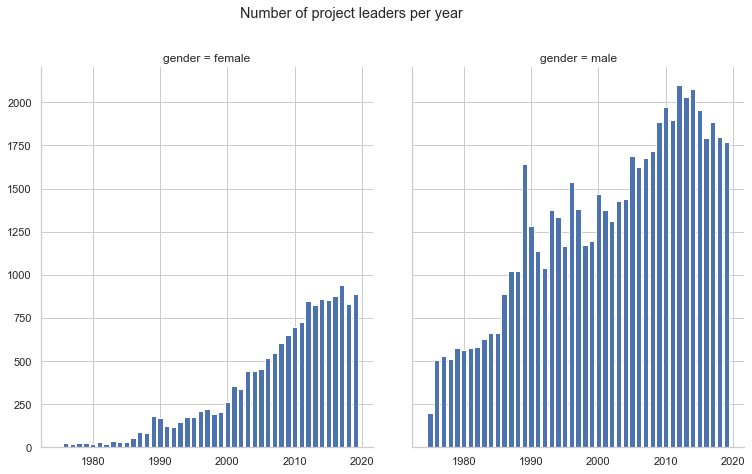

In [15]:
sns.set_style("whitegrid")
g = sns.FacetGrid(col = 'gender', data=annual_stats)
g.map(plt.bar, 'year', 'count')
g.fig.set_figwidth(12)
g.fig.set_figheight(8)
g.set_axis_labels('', '')
g.fig.suptitle('Number of project leaders per year')
g;

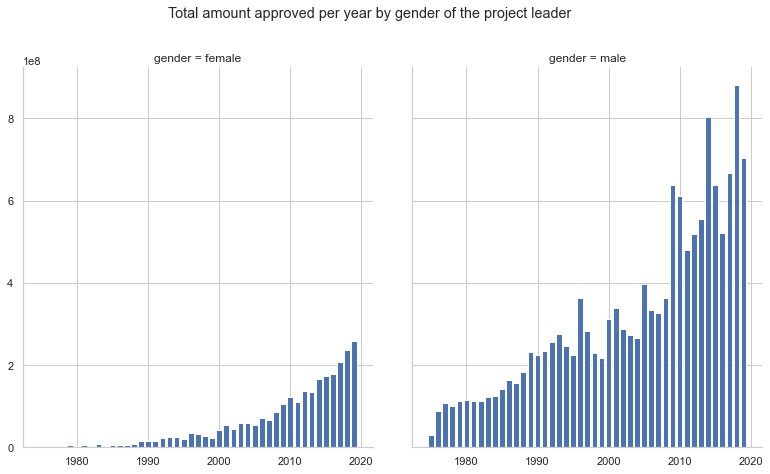

In [16]:
sns.set_style("whitegrid")
g = sns.FacetGrid(col = 'gender', data=annual_stats)
g.map(plt.bar, 'year', 'approved_amount')
g.fig.set_figwidth(12)
g.fig.set_figheight(8)
g.set_axis_labels('', '')
g.fig.suptitle('Total amount approved per year by gender of the project leader')
g;

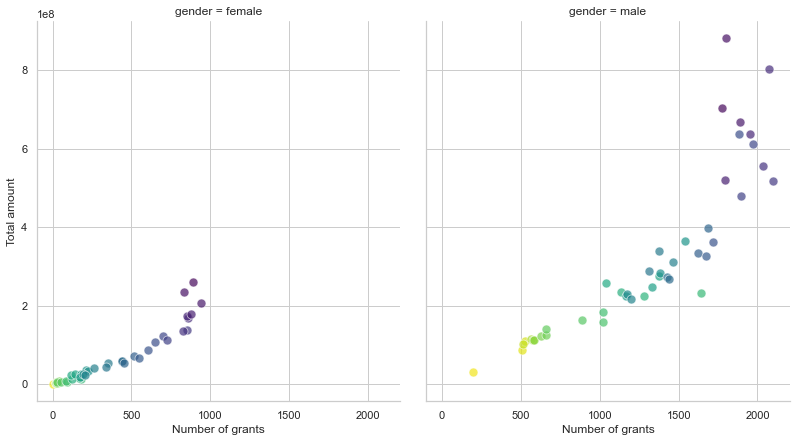

In [17]:
sns.set_style("whitegrid")
g = sns.FacetGrid(col = 'gender', hue='year', palette='viridis_r', data=annual_stats)
g.map(sns.scatterplot, 'count', 'approved_amount', alpha=.7, s=80)
g.fig.set_figwidth(12)
g.fig.set_figheight(8)
g.set_axis_labels("Number of grants", "Total amount")
g;

### Project employees

In [18]:
workforce = grantees.query('role == "employee"').merge(grants, on='project_number')
workforce = workforce.merge(people[['person_id_snsf', 'gender']], on='person_id_snsf')
workforce = workforce.drop(['index_x', 'index_y'], axis=1)

In [19]:
annual_counts = workforce.groupby(['year', 'gender']).size().reset_index().rename(columns={0:'count'})
annual_counts = annual_counts.query('year < 2020')

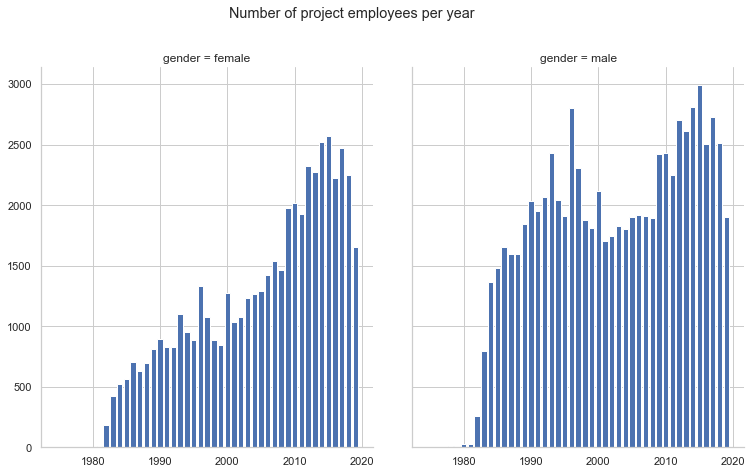

In [20]:
sns.set_style("whitegrid")
g = sns.FacetGrid(col = 'gender', data=annual_counts)
g.map(plt.bar, 'year', 'count')
g.fig.set_figwidth(12)
g.fig.set_figheight(8)
g.set_axis_labels('', '')
g.fig.suptitle('Number of project employees per year')
g;